In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io as sio
import pandas as pd
import random
import scipy 

random.seed(0)
np.random.seed(0)


In [58]:
import scipy.sparse

def mixing_time(T, epsilon=1e-6):
    # Calculate the eigenvalues of the transition matrix
    eigenvalues = scipy.linalg.eig(T, left=False, right=False)
    
    # Find the second largest eigenvalue in absolute value
    abs_eigenvalues = np.abs(eigenvalues)
    abs_eigenvalues.sort()
    
    # The second largest eigenvalue (the first one is 1 for a transition matrix)
    lambda_2 = abs_eigenvalues[-2]
    
    # Mixing time estimate
    t_mix = np.log(1 / epsilon) / (1 - lambda_2)
    
    return t_mix

def load_facebook100(input_dir, name):
    filename = input_dir + '/' + name + '.mat'
    mat = sio.loadmat(filename)

    if 'A' in mat:
        A = mat['A']

    G = nx.from_numpy_array(A)

    # get LCC
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    
    return G0, None

def load_twitter(input_dir):
    G = nx.read_edgelist(input_dir + '/edges.txt', create_using=nx.Graph(), nodetype=int)

    df_s = pd.read_csv(input_dir + '/opinions.txt', sep='\t', header=None)
    s = df_s[1].values
    s /= np.linalg.norm(s)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    return G0, s


def load_reddit(input_dir):
    G = nx.read_edgelist(input_dir + '/edges.txt', create_using=nx.Graph(), nodetype=int)

    df_s = pd.read_csv(input_dir + '/opinions.txt', sep='\t', header=None)
    s = df_s[1].values
    s /= np.linalg.norm(s)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    return G0, s


def load_polblogs(input_dir):
    filename = input_dir + '/edges.csv'
    df = pd.read_csv(filename)
    G = nx.from_pandas_edgelist(df, create_using=nx.Graph, source='source', target='target')
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    return G0, None

def get_fiedler_vector_and_value(G):
    fiedler_vector = nx.fiedler_vector(G, normalized=True)
    fiedler_value = nx.algebraic_connectivity(G)

    return fiedler_vector, fiedler_value

def disparity_minimizing_markov_chain_degroot(G, s=None, polarized=False):

    G = nx.convert_node_labels_to_integers(G, first_label=0)

    d = np.array([G.degree(u) for u in G.nodes()])

    fiedler_vector, fiedler_value = get_fiedler_vector_and_value(G)

    n = len(G)

    assignments = np.sign(fiedler_vector)

    if s is None:
        if not polarized:
            s = np.random.uniform(0, 1, size=n)
        else:
            s = np.zeros(n)
            s[assignments == -1] = np.random.beta(8, 2, size=(assignments == -1).sum())
            s[assignments == 1] = np.random.beta(2, 8, size=(assignments == 1).sum())

    s /= np.linalg.norm(s)

    s_A = s[assignments == 1].sum()
    s_B = s[assignments == -1].sum()

    n_A = (assignments == 1).sum()
    n_B = (assignments == -1).sum()

    q_A = n_A * 1 / (n_A + (s_A / s_B) * n_B)
    q_B = n_B * 1 / (n_A * (s_B / s_A) + n_B)


    T = np.zeros((n, n))

    G = G.to_directed()

    for (i, j) in G.edges():
        if assignments[i] == assignments[j]:
            T[i, j] = 1 / max(d[i], d[j])
        elif assignments[i] == 1 and assignments[j] == -1:
            T[i, j] = 1 / max(d[i], s_B / s_A * d[j])
        elif assignments[i] == -1 and assignments[j] == 1:
            T[i, j] = 1 / max(d[i], s_A / s_B * d[j])

    for i in range(len(G)):
        T[i, i] = 1 - T[i, :].sum()

    
    return T, assignments, s, s_A, s_B, q_A, q_B, n_A, n_B

def plot_disparirty_minimizing_markov_chain_degroot(G, s=None, polarized=False):
    T, assignments, s, s_A, s_B, q_A, q_B, n_A, n_B = disparity_minimizing_markov_chain_degroot(G, s=s, polarized=polarized)

    plt.figure()

    pos = nx.spring_layout(G, seed=0)

    node_list_red = [i for i in range(len(G)) if assignments[i] == 1]
    node_list_blue = [i for i in range(len(G)) if assignments[i] == -1]

    s_mean = s.mean()

    node_color_red = [abs(s[i] - s_mean) for i in node_list_red]
    node_color_blue = [abs(s[i] - s_mean) for i in node_list_blue]

    vmax = max(max(node_color_red), max(node_color_blue))
    vmin = 0

    nx.draw_networkx_nodes(G=G, pos=pos, nodelist=node_list_red, node_color=node_color_red, cmap=plt.cm.Reds, alpha=1, node_size=100, vmin=vmin, vmax=vmax)
    nx.draw_networkx_nodes(G=G, pos=pos, nodelist=node_list_blue, node_color=node_color_blue, cmap=plt.cm.Blues, alpha=1, node_size=100, vmin=vmin, vmax=vmax)

    # draw edges based on matrix T
    weights = []

    for (i, j) in G.edges():
        weights.append(np.log(T[i, j]))

    # draw curved edges
    nx.draw_networkx_edges(G=G, pos=pos, edge_color=weights, edge_cmap=plt.cm.Greys, edge_vmin=min(weights), edge_vmax=max(weights), connectionstyle='arc3,rad=0.1')

    mixingtime = mixing_time(T)


    plt.title(f'$S_A/S_B = {s_A/s_B:.2f}, Q_A/Q_B = {q_A / q_B:.2f}, |A|/|B| = {n_A/n_B:.2f}, t_{{mix}} = {mixingtime:.2f}$')

    # disable axis
    plt.axis('off')

    plt.savefig(f'disparity_minimizing_markov_chain{"_polarized" if polarized else ""}.pdf', bbox_inches='tight')

def plot_disparirty_gradient_friedkin_johnsen(G, num_steps=100, eta=1e-3):
    n = len(G)
    G0 = G.copy()

    # Get row normalized adjacency matrix
    A0 = nx.adjacency_matrix(G).toarray()
    D0_inv = np.diag(1 / np.sum(A0, axis=1))

    W0 = D0_inv @ A0

    W = W0.copy()

    I = np.eye(n)

    B = nx.incidence_matrix(G).toarray()

    for i in range(num_steps):
        L = I - W
        eigvals, eigvecs = np.linalg.eigh(L)
        X = eigvecs @ np.diag(1 / (1 + eigvals)**3) @ eigvecs.T
        gradient = ((-2/n) * B.T @ X @ B)

        print(gradient.shape)

        for (u, v) in G.edges():
            W[u, v] -= eta * gradient[u, v]
            W[v, u] -= eta * gradient[v, u]

        D_inv = np.diag(1 / np.sum(W, axis=1))
        W = D_inv @ W

    plt.figure()

    pos = nx.spring_layout(G, seed=0)

    nx.draw_networkx_nodes(G=G, pos=pos, nodelist=G.nodes(), node_color='black', node_size=50)

    edge_color = ['r' if W0[i,j] > W[i,j] else 'b' for (i, j) in G.edges()]

    # draw curved edges
    nx.draw_networkx_edges(G=G, pos=pos, edge_color=edge_color)

    plt.axis('off')

    plt.savefig(f'disparity_gradient_friedkin_johnsen.pdf', bbox_inches='tight')


def disparity_minimizing_markov_chain_friedkin_johnsen(G):

    # Get the adjacency matrix (A) and the degree matrix (D)
    d = np.array([G.degree(u) for u in G.nodes()])
    n = len(G)

    fiedler_vector, fiedler_value = get_fiedler_vector_and_value(G)

    disparity = 1 / (1 + fiedler_value)**2
    # do assignments based on the sign of the fiedler vector

    assignments = (np.sign(fiedler_vector) + 1) / 2

    s = np.abs(fiedler_vector)
    s /= np.linalg.norm(s)

    n_A = (assignments == 1).sum()
    n_B = (assignments == 0).sum()

    return s, fiedler_value, disparity, n_A, n_B

<class 'networkx.utils.decorators.argmap'> compilation 13:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 13:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_80392/390403643.py:167: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A0 = nx.adjacency_matrix(G).toarray()
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_80392/390403643.py:176: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  B = nx.incidence_matrix(G).toarray()


(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)
(78, 78)


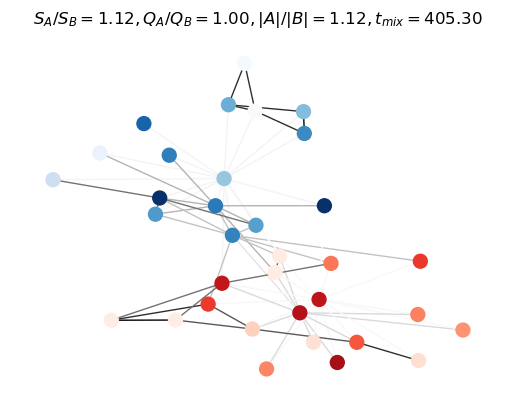

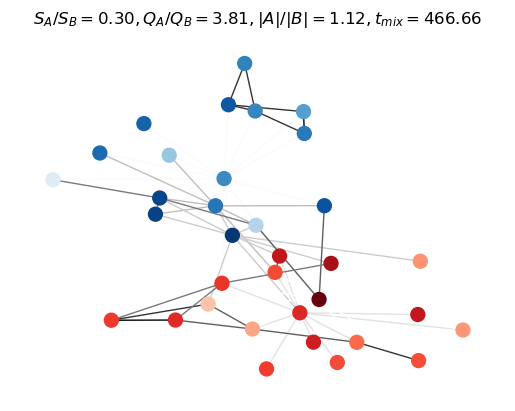

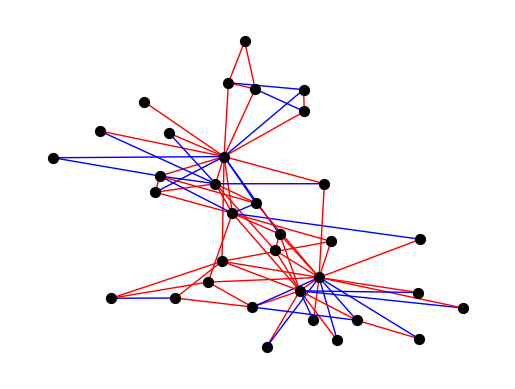

In [59]:
plot_disparirty_minimizing_markov_chain_degroot(nx.karate_club_graph())
plot_disparirty_minimizing_markov_chain_degroot(nx.karate_club_graph(), polarized=True)

plot_disparirty_gradient_friedkin_johnsen(nx.karate_club_graph())

In [57]:
graphs = [
          ((nx.karate_club_graph(), None), 'Karate Club'),  
          ((nx.les_miserables_graph(), None), 'Les Miserables'),
          (load_facebook100('data/facebook100', 'Caltech36'), 'Caltech'),
          (load_facebook100('data/facebook100', 'Swarthmore42'), 'Swarthmore'),
          (load_polblogs('data/polblogs'), 'Political Blogs'),
          (load_twitter('data/twitter'), 'Twitter'),
        ]

records = []

for (G, s), name in graphs:
  
  s_fj, fiedler_value_fj, disparity_fj, n_A, n_B = disparity_minimizing_markov_chain_friedkin_johnsen(G)
  T_dg, assignments_dg, s_dg, s_A_dg, s_B_dg, q_A_dg, q_B_dg, n_A_dg, n_B_dg = disparity_minimizing_markov_chain_degroot(G)
  
  records.append({
    'Name' : name,
    '$n$' : len(G),
    '$m$' : G.number_of_edges(),
    'Cluster Imbalance' : max(n_A_dg / n_B_dg, n_B_dg / n_A_dg),
    'Total Probability Mass Imbalance (DG)' : max(q_A_dg / q_B_dg, q_B_dg / q_A_dg),
    'Mixing Time (DG)' : mixing_time(T_dg),
    'Fiedler Value (FJ)' : fiedler_value_fj,
    'Disparity (FJ)' : disparity_fj,
  })

  if s is not None:
    print(f'{name}: Distance from ground truth' , np.linalg.norm(s - s_dg))
    
df = pd.DataFrame(records)

# sort by $n$
df = df.sort_values('$n$')

with open('table.tex', 'w') as f:
  f.write(df.to_latex(index=False, float_format='%.3f'))

<class 'networkx.utils.decorators.argmap'> compilation 13:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Twitter: Distance from ground truth 0.5078907810653418


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_80392/3423439404.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df.to_latex(index=False, float_format='%.3f'))
